In [1]:
import pandas as pd
import os
from config import *

df = pd.read_csv(actuales)

In [123]:
data = df.loc[df["tipoPropiedad"]=="DEPARTAMENTO"]
data = data.loc[data["coordX"].notna()]

data["terrenoEdificadoNormalized"] = (
  data["terrenoEdificado"] - data["terrenoEdificado"].mean())/data["terrenoEdificado"].std()

data["precioUSDNormalized"] = (data["precioUSD"] - data["precioUSD"].mean())/data["precioUSD"].std()

data.loc[:, "pm2"] = data["precioUSD"]/data["terrenoEdificado"]

data = data.loc[(data["pm2"] < data["pm2"].quantile(0.99)) & (data["pm2"] > data["pm2"].quantile(0.01))]
data.loc[:, "pm2Normalized"] = (data["pm2"] - data["pm2"].mean())/data["pm2"].std()

data["terrenoTotalNormalized"] = (
  data["terrenoTotal"] - data["terrenoTotal"].mean())/data["terrenoTotal"].std()

In [124]:
from math import radians, sin, cos, sqrt, atan2

def calcular_distancia(coord1, coord2):
    # Radio de la Tierra en kilómetros
    radio_tierra = 6371.0

    # Convertir las coordenadas de grados a radianes
    latitud1, longitud1 = radians(coord1[0]), radians(coord1[1])
    latitud2, longitud2 = radians(coord2[0]), radians(coord2[1])

    # Diferencia de latitud y longitud
    dlat = latitud2 - latitud1
    dlon = longitud2 - longitud1

    # Fórmula de la distancia haversine
    a = sin(dlat / 2)**2 + cos(latitud1) * cos(latitud2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Distancia en kilómetros
    distancia = radio_tierra * c

    return distancia

centroCBA = (-31.4201, -64.1888)

data = data.loc[(data["coordX"] < data["coordX"].quantile(0.99)) & (data["coordX"] > data["coordX"].quantile(0.01))]
data = data.loc[(data["coordY"] < data["coordY"].quantile(0.99)) & (data["coordY"] > data["coordY"].quantile(0.01))]
data["distanciaCentro"] = data.apply(lambda x: calcular_distancia(centroCBA, (x["coordX"], x["coordY"])), axis=1)

data.loc[:, "distanciaCentroNormalized"] = (data["distanciaCentro"] - data["distanciaCentro"].mean())/data["distanciaCentro"].std()

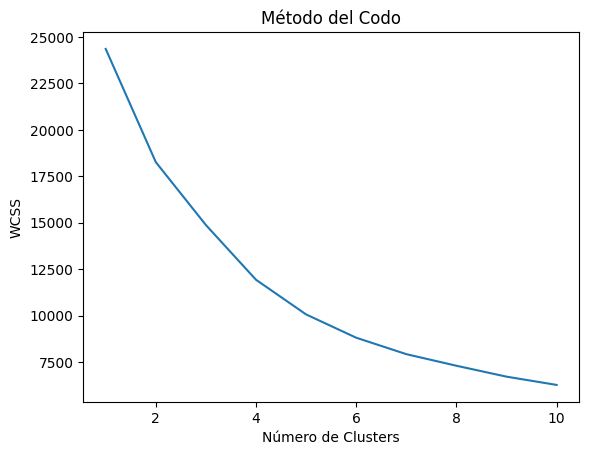

In [125]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Seleccionar las columnas relevantes para el clustering
features = ['pm2Normalized', 'terrenoEdificadoNormalized', 'precioUSDNormalized', 'coordX', 'coordY']
data_for_clustering = data[features]

# Escalar los datos para que todas las características tengan la misma escala
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

# Determinar el número óptimo de clusters utilizando el método del codo
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=100, random_state=33)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Visualizar el método del codo para encontrar el número óptimo de clusters
plt.plot(range(1, 11), wcss)
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')  # Within-Cluster Sum of Squares
plt.show()


In [126]:
# Elegir el número óptimo de clusters (en este caso, por ejemplo, 3 clusters)
n_clusters = 5
# Aplicar el algoritmo de K-Means
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=500, n_init=200, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Agregar la información de los clusters al DataFrame original
data['cluster'] = clusters

info_clusters = data.loc[:, ["cluster", "pm2", "terrenoEdificado", "precioUSD", "coordX", "coordY"]].groupby('cluster').describe()

# Redondear los valores a 2 decimales
info_clusters = info_clusters.round(2)

# Imprimir las medias de cada característica para cada cluster
info_clusters.to_excel("info_clusters.xlsx")


In [127]:
colors = {0: '#1d3557',  
          1: '#7d1538',  
          2: '#0f8b8d',  
          3: '#f7b32b',  
          4: '#fac8cd',
          5: '#0cce6b'}  

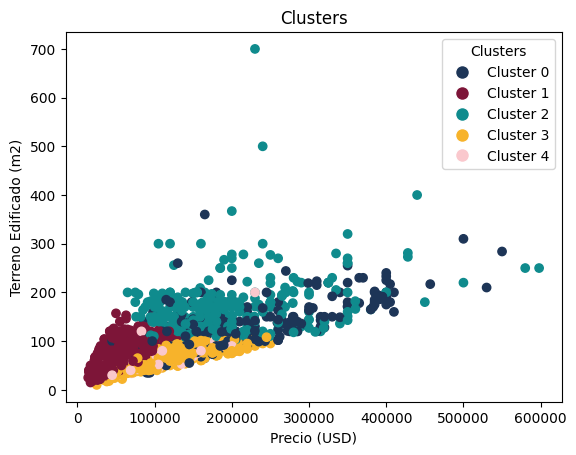

In [128]:
# Graficar los clusters
scatter = plt.scatter(data["precioUSD"], data["terrenoEdificado"], c=[colors[cluster] for cluster in clusters])
plt.title('Clusters')
plt.xlabel('Precio (USD)')
plt.ylabel('Terreno Edificado (m2)')

# Agregar leyenda para cada cluster
legend_labels = list(set(clusters))  # Obtener los valores únicos de clusters
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label], markersize=10) for label in legend_labels]
plt.legend(legend_handles, [f'Cluster {label}' for label in legend_labels], title='Clusters')

plt.show()

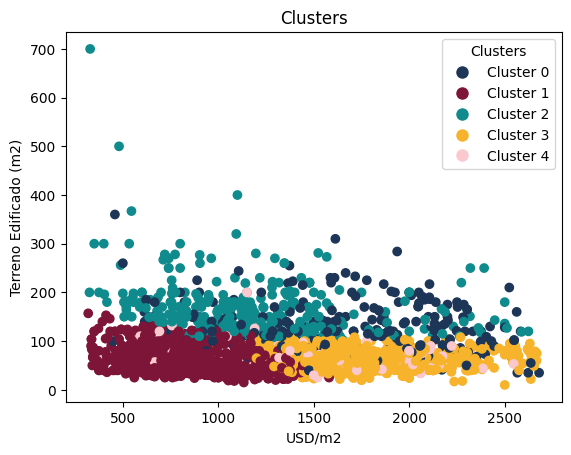

In [129]:
scatter = plt.scatter(data["pm2"], data["terrenoEdificado"], c=[colors[cluster] for cluster in clusters])
plt.title('Clusters')
plt.xlabel('USD/m2')
plt.ylabel('Terreno Edificado (m2)')

# Agregar leyenda para cada cluster
legend_labels = list(set(clusters))  # Obtener los valores únicos de clusters
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label], markersize=10) for label in legend_labels]
plt.legend(legend_handles, [f'Cluster {label}' for label in legend_labels], title='Clusters')

plt.show()

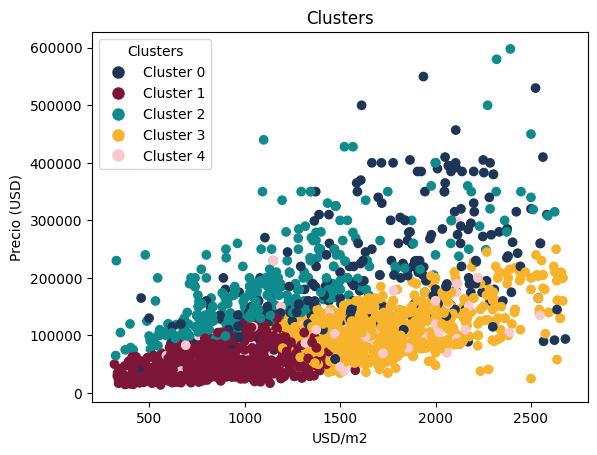

In [130]:
scatter = plt.scatter(data["pm2"], data["precioUSD"], c=[colors[cluster] for cluster in clusters])
plt.title('Clusters')
plt.xlabel('USD/m2')
plt.ylabel('Precio (USD)')

# Agregar leyenda para cada cluster
legend_labels = list(set(clusters))  # Obtener los valores únicos de clusters
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label], markersize=10) for label in legend_labels]
plt.legend(legend_handles, [f'Cluster {label}' for label in legend_labels], title='Clusters')

plt.show()

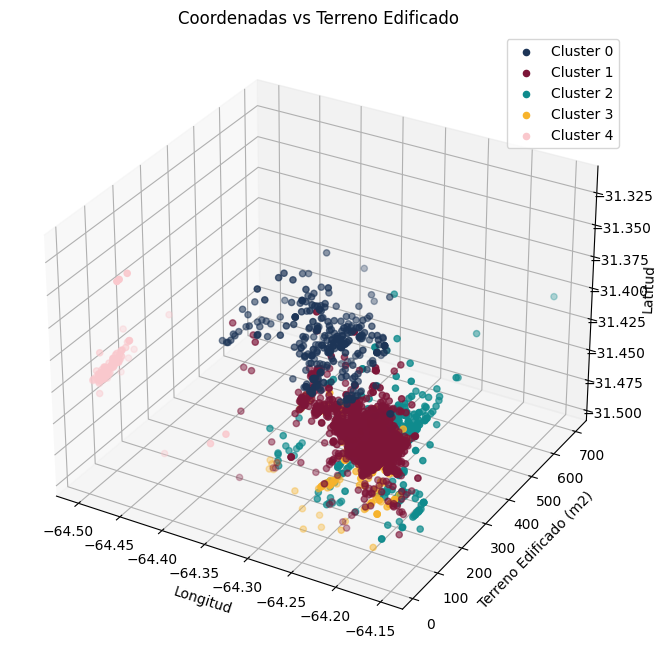

In [131]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Crear la figura tridimensional
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Iterar sobre el DataFrame y graficar cada punto con su respectivo color
for cluster, color in colors.items():
    subset = data[data['cluster'] == cluster]
    if not subset.empty:
        ax.scatter(subset['coordY'], subset['terrenoEdificado'], subset['coordX'], c=color, label=f'Cluster {cluster}')

# Configurar etiquetas y título
ax.set_zlabel('Latitud')
ax.set_xlabel('Longitud')
ax.set_ylabel('Terreno Edificado (m2)')
ax.set_title('Coordenadas vs Terreno Edificado')

# Mostrar la leyenda
ax.legend()

# Mostrar el gráfico
plt.show()


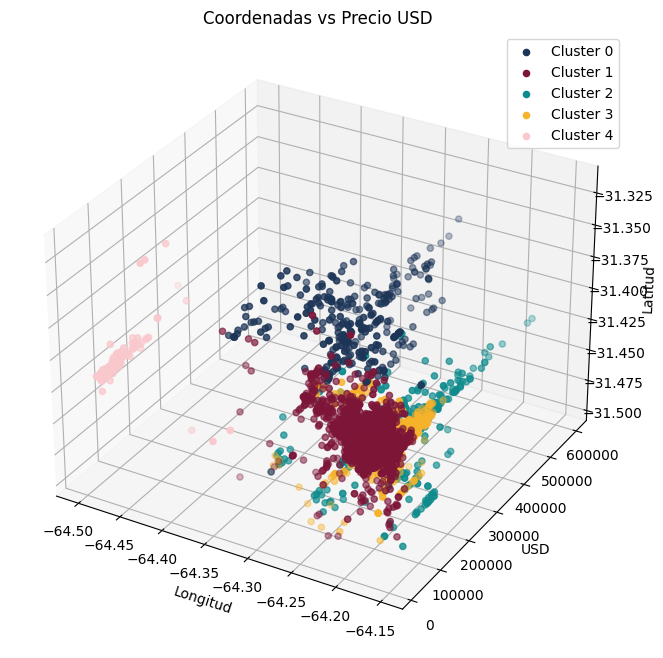

In [132]:
import matplotlib.pyplot as plt

# Crear la figura tridimensional
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Iterar sobre el DataFrame y graficar cada punto con su respectivo color
for cluster, color in colors.items():
    subset = data[data['cluster'] == cluster]
    if not subset.empty:
        ax.scatter(subset['coordY'], subset['precioUSD'], subset['coordX'], c=color, label=f'Cluster {cluster}')

# Configurar etiquetas y título
ax.set_xlabel('Longitud')
ax.set_ylabel('USD')
ax.set_zlabel('Latitud')
ax.set_title('Coordenadas vs Precio USD')

# Mostrar la leyenda
ax.legend()

# Mostrar el gráfico
plt.show()


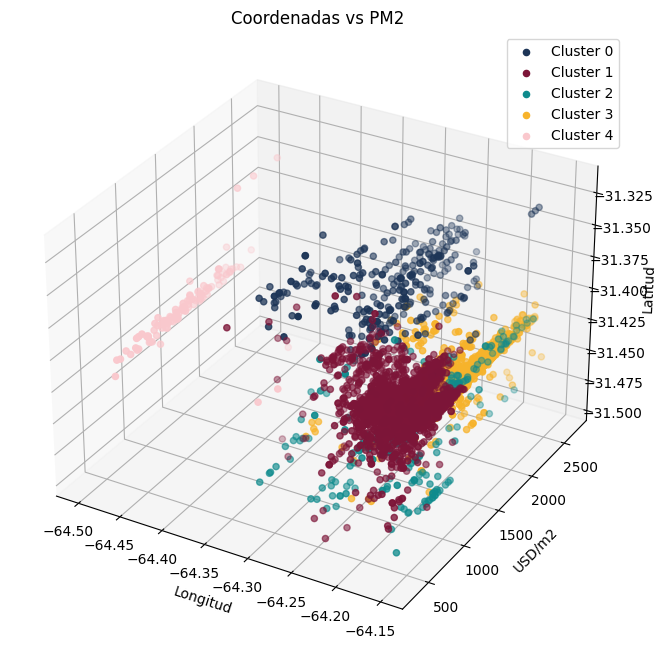

In [133]:
import matplotlib.pyplot as plt

# Crear la figura tridimensional
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Iterar sobre el DataFrame y graficar cada punto con su respectivo color
for cluster, color in colors.items():
    subset = data[data['cluster'] == cluster]
    if not subset.empty:
        ax.scatter(subset['coordY'], subset['pm2'], subset['coordX'], c=color, label=f'Cluster {cluster}')

# Configurar etiquetas y título
ax.set_xlabel('Longitud')
ax.set_ylabel('USD/m2')
ax.set_zlabel('Latitud')
ax.set_title('Coordenadas vs PM2')

# Mostrar la leyenda
ax.legend()

# Mostrar el gráfico
plt.show()


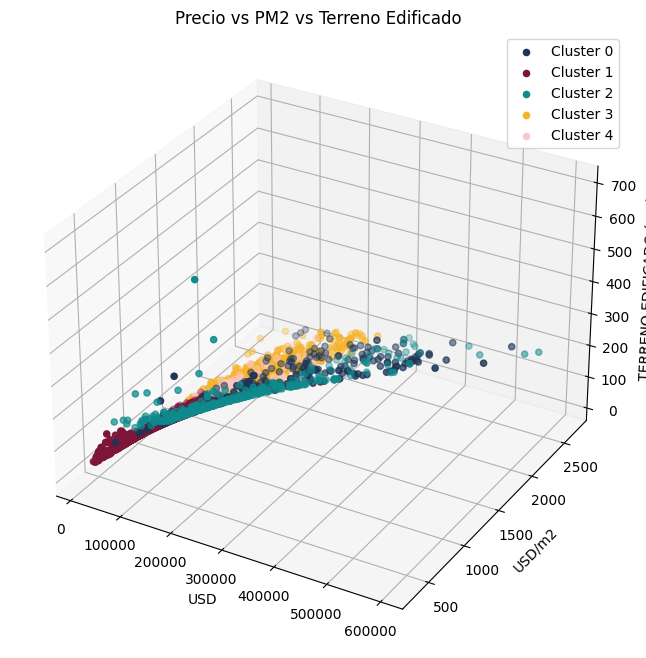

In [141]:
import matplotlib.pyplot as plt

# Crear la figura tridimensional
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Iterar sobre el DataFrame y graficar cada punto con su respectivo color
for cluster, color in colors.items():
    subset = data[data['cluster'] == cluster]
    if not subset.empty:
        ax.scatter(subset['precioUSD'], subset['pm2'], subset['terrenoEdificado'], c=color, label=f'Cluster {cluster}')

# Configurar etiquetas y título
ax.set_xlabel('USD')
ax.set_ylabel('USD/m2')
ax.set_zlabel('TERRENO EDIFICADO (m2)')
ax.set_title('Precio vs PM2 vs Terreno Edificado')

# Mostrar la leyenda
ax.legend()

# Mostrar el gráfico
plt.show()


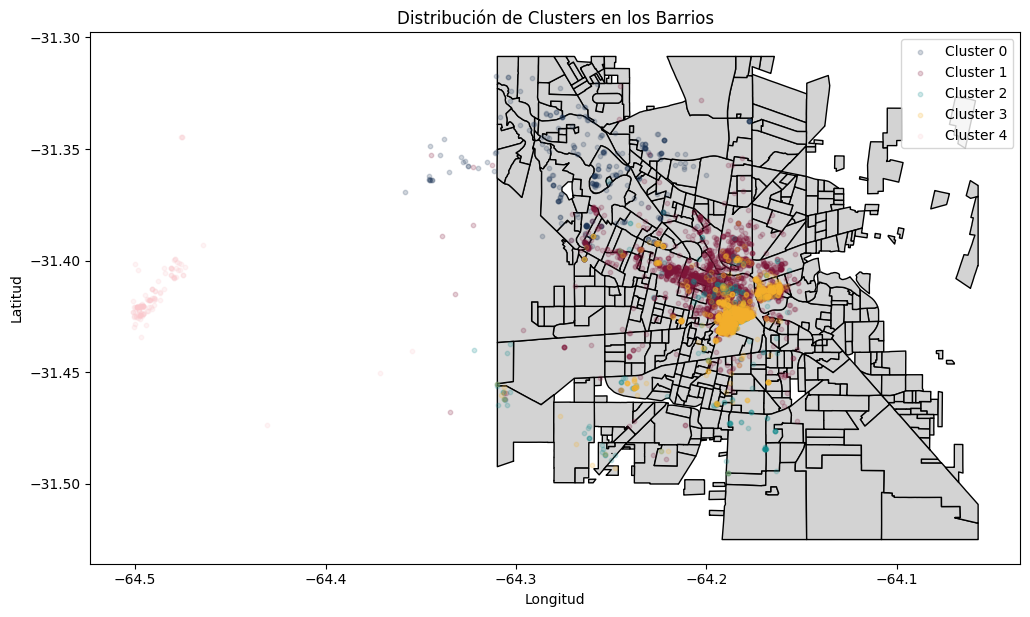

In [134]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Cargar el shapefile de los barrios
barrios = gpd.read_file(map_barrios)

# Crear un GeoDataFrame con los datos de tus inmuebles
geometry = [Point(xy) for xy in zip(data["coordY"], data["coordX"])]
inmuebles_gdf = gpd.GeoDataFrame(data, geometry=geometry, crs=barrios.crs)

# Plotear el mapa de los barrios
fig, ax = plt.subplots(figsize=(12, 12))
barrios.plot(ax=ax, color='lightgray', edgecolor='black')

# Ajustar el aspecto del eje
ax.set_aspect('equal')

clusters_unicos = list(set(clusters))

for cluster in clusters_unicos:
    cluster_points = inmuebles_gdf[inmuebles_gdf['cluster'] == cluster]
    cluster_points.plot(ax=ax, color=colors[cluster], label=f'Cluster {cluster}', markersize=10, alpha=0.2)

# Añadir leyenda y etiquetas
ax.legend()
plt.title('Distribución de Clusters en los Barrios')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()


In [135]:
from scipy.stats import mode

# Crear un diccionario para almacenar el cluster modal de cada polígono
modal_clusters = {}

# Iterar sobre los polígonos
for index, barrio in barrios.iterrows():
    # Filtrar los puntos que están dentro del polígono
    points_in_barrio = inmuebles_gdf[inmuebles_gdf.geometry.within(barrio.geometry)]
    # Verificar si hay puntos en el polígono
    if not points_in_barrio.empty:
        # Calcular el cluster modal
        modal_cluster = mode(points_in_barrio['cluster']).mode
    else:
        # Si no hay puntos en el polígono, asignar -1
        modal_cluster = -1
    
    # Almacenar el resultado en el diccionario
    modal_clusters[barrio['Nombre']] = modal_cluster


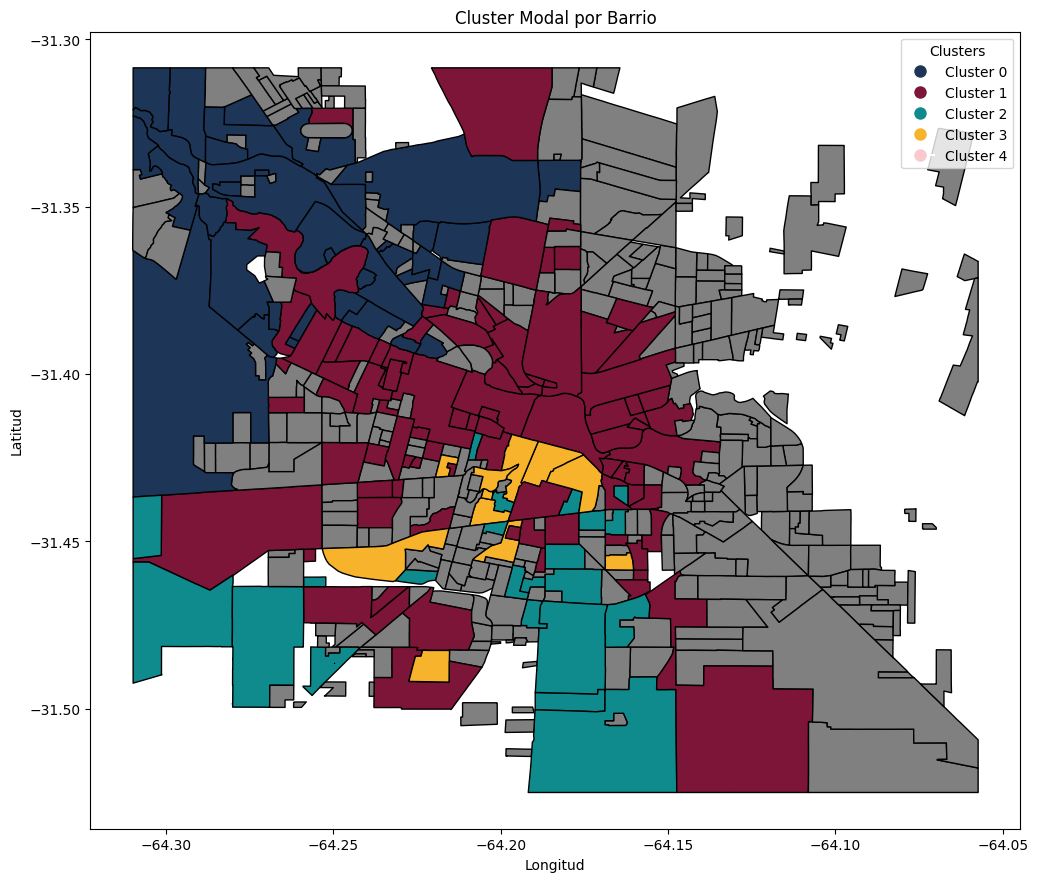

In [136]:
# Importar la clase Legend de Matplotlib
from matplotlib.lines import Line2D

# Restaurar el código de colores
colors[-1] = 'gray'

# Agregar una nueva columna al DataFrame de barrios con el cluster modal
barrios['modal_cluster'] = barrios['Nombre'].map(modal_clusters)

# Plotear el mapa de los barrios con colores según el cluster modal
fig, ax = plt.subplots(figsize=(12, 12))
barrios.plot(ax=ax, color=barrios['modal_cluster'].map(colors), edgecolor='black')

clusters_unicos = list(set(clusters))
# Crear una leyenda personalizada
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[cluster], markersize=10, label=f'Cluster {cluster}') for cluster in clusters_unicos]

# Ajustar el aspecto del eje
ax.set_aspect('equal')

# Añadir la leyenda personalizada
ax.legend(handles=legend_elements, title='Clusters', loc='upper right')

# Añadir etiquetas
plt.title('Cluster Modal por Barrio')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()
